# Plot and select regional bull kelp data for MS
### Author: Marisol García-Reyes
#### Created: July 2021, Modified: January 2022
***

## Data available at (netcdf file, 1984-2020):
### https://sbclter.msi.ucsb.edu/data/catalog/package/?package=knb-lter-sbc.74

### for Northern California only area available, representing Bull Kelp coverage.  Units: m2/900m2 per pixel
### Summer data aggregated (sum) in 0.01 deg lat bins, for the entire region, and north/south of Point Arena
### Clean data: Selected years with > 90% of data available along the latitude range (entire NorCal, North/South of Point Arena at 39N). Average data, multiply by the # of bins

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib.colors as colors
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
 
import warnings
warnings.simplefilter('ignore') #filter some warning messages"

In [2]:
# read kelp data and select northern california data
tmp = xr.open_dataset('../data/kelpCanopyFromLandsat_2020_v2.nc')
# downloaded July 2021
tmp.close()
# select only northern california
lat1= 38.4 # Jenner-> 39N north of point arena
lat2= 39.8 #39.5 # north of fort bragg (10 mi beach)
ds = tmp.where((tmp.lat>=lat1) & (tmp.lat<=lat2), drop=True)
ds

<xarray.Dataset>
Dimensions:     (station: 22247, time: 148)
Dimensions without coordinates: station, time
Data variables:
    lat         (station) float64 38.48 38.48 38.48 38.48 ... 39.71 39.72 39.75
    lon         (station) float64 -123.2 -123.2 -123.2 ... -123.8 -123.8 -123.8
    year        (time, station) float64 1.984e+03 1.984e+03 ... 2.02e+03
    quarter     (time, station) float64 1.0 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    area        (time, station) float64 nan nan nan nan nan ... nan nan nan nan
    area_se     (time, station) float64 nan nan nan nan nan ... nan nan nan nan
    biomass     (time, station) float64 nan nan nan nan nan ... nan nan nan nan
    biomass_se  (time, station) float64 nan nan nan nan nan ... nan nan nan nan
    passes      (time, station) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    passes4_5   (time, station) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    passes7     (time, station) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    passes8     (time, station) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

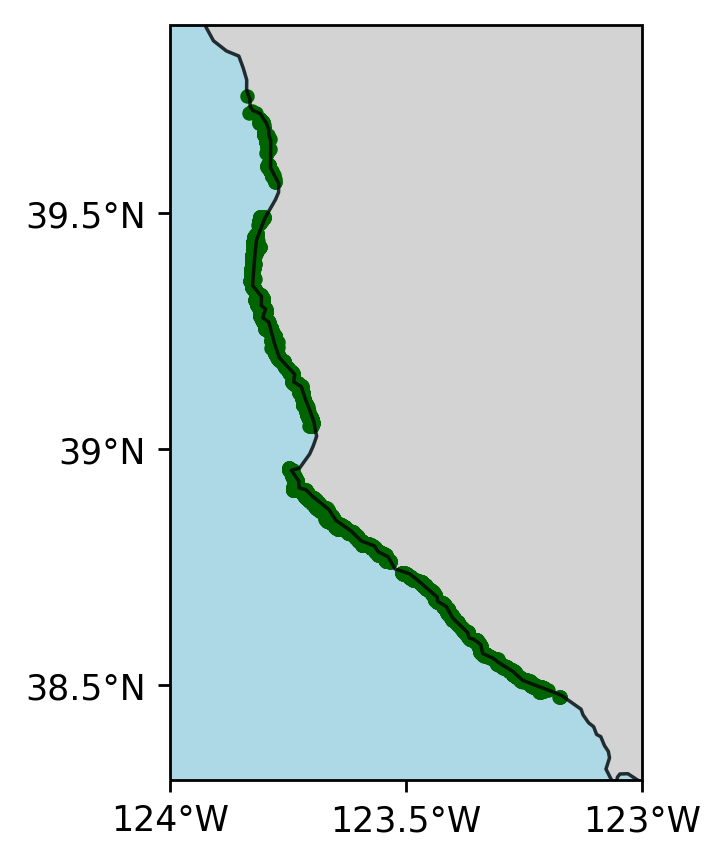

In [7]:
# plot map of region where kelp is present
plt.figure(figsize=(5.5,4),dpi=250)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1,color='black',alpha=0.8,zorder=1)
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.set_extent([-124,-123,lat1-0.1,lat2+0.1],crs=ccrs.PlateCarree())
ax.set_xticks([-124,-123.5,-123], crs=ccrs.PlateCarree())
ax.set_yticks([38.5,39,39.5], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.scatter(ds.lon,ds.lat, 10, 'darkgreen')
plt.grid(True, zorder=2,alpha=0.5)
ax.set_aspect(1)
plt.savefig('../figures/Fig_1_a.png')
plt.show()

In [ ]:
# big Map 
fig=plt.figure(figsize=(3,3),dpi=250)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m',linewidth=2,color='black',alpha=0.8,zorder=2)
ax.add_feature(cfeature.STATES,zorder=2)
ax.set_extent([-125,-115,31,43],crs=ccrs.PlateCarree())
#ax.set_xticks([-125,-120,-115], crs=ccrs.PlateCarree())
#ax.set_yticks([32,36,40], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=0,alpha=0.5)
plt.plot([-124,-123,-123,-124,-124],[lat1-0.1,lat1-0.1,lat2+0.1,lat2+0.1,lat1-0.1],c='k')
plt.scatter(ds.lon,ds.lat, 5, c='darkgreen',zorder=3)
ax.set_aspect(1.2)
plt.savefig('../figures/Fig_1_b.png')
plt.show()


In [ ]:
# select data by latitude bin of 0.01 degrees
kelp = np.full((len(np.arange(ds.lat.min(),ds.lat.max(),0.01)),len(ds.area[:,0])),np.nan)
kelp_seas = np.full((4,len(np.arange(ds.lat.min(),ds.lat.max(),0.01)),int(len(ds.area[:,0])/4)),np.nan)
for li, l in enumerate(np.arange(ds.lat.min(),ds.lat.max(),0.01)):
    lat1 = l
    lat2 = l+0.01
    # count the number of grid cells per latitude
    tmp2 = ds.area.where((ds.lat>=lat1) & (ds.lat<=lat2), drop=True).count(dim=['station'])
    #print(tmp2)
    # select a threshold for when there is enough data points available at this latitude per time step.
    # 90% of median number of data (max can be too much since it can extend offshore in productive years)
    thr = np.median(tmp2)*0.90
    tmp1 = ds.area.where((ds.lat>=lat1) & (ds.lat<=lat2), drop=True).sum(dim=['station'],skipna=True, keep_attrs=True)
    fech = ds.quarter.where((ds.lat>=lat1) & (ds.lat<=lat2), drop=True).mean(dim=['station'],skipna=True, keep_attrs=True).values
    tmp1 = (tmp1)*(tmp2.where(tmp2>=thr))
    kelp[li,:] = (tmp1.values+1)
    for j in range(4):
        a1 = fech==j+1
        if a1.any():
            kelp_seas[j,li,:] = (tmp1[a1].values+1)    

In [ ]:
# plot all seasons
fechas = ds.year[:,0].values+(ds.quarter[:,0].values-1)/4
lats = np.asarray([*np.arange(ds.lat.min(),ds.lat.max(),0.01)])

xl,yl=kelp.shape
kelp2 = np.full((xl+1,yl+1),np.nan)
kelp2[:-1,:-1]=kelp
years2 = np.full((len(fechas)+1),np.nan)
years2[:-1]=fechas
years2[-1]=years2[-2]+0.25
lats2 = np.full((len(lats)+1),np.nan)
lats2[:-1]=lats
lats2[-1] = lats2[-2]+0.01
plt.figure(figsize=(10,5))
plt.pcolormesh(years2, lats2, np.log(kelp2), cmap='viridis')
plt.colorbar()
plt.ylabel('Latitude')
plt.show()

In [ ]:
# plot only summer
years = np.unique(ds.year.values)
z,xl,yl=kelp_seas.shape
kelp_su2 = np.full((xl+1,yl+1),np.nan)
kelp_su2[:-1,:-1]=kelp_seas[2,:,:]
years2 = np.full((len(years)+1),np.nan)
years2[:-1]=years
years2[-1]=years2[-2]+1
lats2 = np.full((len(lats)+1),np.nan)
lats2[:-1]=lats
lats2[-1] = lats2[-2]+0.01
plt.figure(figsize=(8,4))
plt.pcolormesh(years2, lats2, np.log(kelp_su2), cmap='viridis')
plt.colorbar()
plt.ylabel('Latitude')
plt.show()

In [ ]:
# aggregate kelp along latitude - only summer
# 3 regions: north/south of point arena, and entire region
# sum ok, but ignore years with many nans
years = np.asarray(np.unique(ds.year.values)).astype(int)
thr_perc = .90 # percentage of data necesary to count as a year
kelp_su = kelp_seas[2,:,:]
# entire region
mxbins = np.count_nonzero(~np.isnan(kelp_su),axis=0).max() # max number of lat bins - do not change w years
selyrs = np.count_nonzero(~np.isnan(kelp_su),axis=0)>mxbins*thr_perc #select years w enough
kelpall = np.nansum(kelp_su[:,selyrs],axis=0)/1000000
yrsall = years[selyrs]
SoMe = pd.DataFrame(data=kelpall, index=yrsall, columns=['All Kelp'])

# North of Point Arena
ktmp = kelp_su[lats>=39,:]
mxbins = np.count_nonzero(~np.isnan(ktmp),axis=0).max() # max number of lat bins
selyrs = np.count_nonzero(~np.isnan(ktmp),axis=0)>mxbins*thr_perc #select years w enough
kelpall = np.nansum(ktmp[:,selyrs],axis=0)/1000000
yrsall = years[selyrs]
NorKelp = pd.DataFrame(data=kelpall, index=yrsall, columns=['North Kelp'])

# South of Point Arena
ktmp = kelp_su[lats<=39,:]
mxbins = np.count_nonzero(~np.isnan(ktmp),axis=0).max() # max number of lat bins
selyrs = np.count_nonzero(~np.isnan(ktmp),axis=0)>mxbins*thr_perc #select years w enough
kelpall = np.nansum(ktmp[:,selyrs],axis=0)/1000000
yrsall = years[selyrs]
SoKelp = pd.DataFrame(data=kelpall, index=yrsall, columns=['South Kelp'])

# all years
yrs = pd.DataFrame(data=years, index=years, columns=['Years'])

AKelp = pd.concat([yrs,SoMe, NorKelp, SoKelp], axis=1)
AKelp = AKelp.drop(['Years'], axis=1)
AKelp = AKelp[AKelp.index>=1991]
AKelp.to_csv('../data/BullKelp_summer_July2021.csv')
AKelp

In [ ]:
# plot both regions for figure 1
fig, ax1 = plt.subplots(dpi=300)
ax1.plot(AKelp.index,AKelp['North Kelp']+1,'d-',c='darkorange')
ax1.set_ylabel('Kelp North of Point Arena (km$^2$)', color='darkorange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(AKelp.index,AKelp['South Kelp']+1,'o-', c='grey')
ax2.set_ylabel('Kelp South of Point Arena (km$^2$)', color='grey', fontsize=12)
ax2.tick_params(axis='y', labelcolor='grey')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Year', c='k')
ax2.set_xticks([*range(1990,2021,5)])
plt.savefig('../figures/Fig_1_c.png')
plt.show()

In [ ]:
# linear regression, for trends
def linreg_deg1(x,y):

    # clean, ready variables
    bx = ~np.isnan(x)
    by = ~np.isnan(y)
    nx = x[bx&by]
    ny = np.log(y[bx&by]+1)
    nx = nx.reshape(-1,1)
    #ny = ny.reshape(-1,1)

    # first degree
    polf = PolynomialFeatures(1)
    xp = polf.fit_transform(nx)
    mods2 = sm.OLS(ny,xp).fit()
    
    # only if significant, return r2 value
    if mods2.pvalues[1]<=1:
        r2 = mods2.rsquared
        
        # print summary
        #print(mods2.summary())
        lab='R2='+str(np.round(mods2.rsquared,2))
        print(lab)
        print('AIC = ',np.round(mods2.aic,1))
        
        print(mods2.summary())


AKelp3 = AKelp[(AKelp.index<2014)&(AKelp.index>=1991)]
print('North Kelp')
linreg_deg1(AKelp3.index.values,AKelp3['North Kelp'])
print('\n\nSouth Kelp')
linreg_deg1(AKelp3.index.values,AKelp3['South Kelp'])

In [ ]:
# agregate data for other seasons and compare among them
sesnm=['winter','spring','summer','fall']
years = np.asarray(np.unique(ds.year.values)).astype(int)
thr_perc = .90 # percentage of data necesary to count as a year

for i in range(4):
    tmp = kelp_seas[i,:,:]

    # North of Point Arena
    ktmp = tmp[lats>=39,:]
    mxbins = np.count_nonzero(~np.isnan(ktmp),axis=0).max() # max number of lat bins
    selyrs = np.count_nonzero(~np.isnan(ktmp),axis=0)>mxbins*thr_perc #select years w enough
    kelpall = np.nansum(ktmp[:,selyrs],axis=0)/1000000
    yrsall = years[selyrs]
    if i==0:
        kelp_north_4s = pd.DataFrame(data=kelpall, index=yrsall, columns=[sesnm[i]])
    else:
        tmp2 = pd.DataFrame(data=kelpall, index=yrsall, columns=[sesnm[i]])
        kelp_north_4s = pd.concat([kelp_north_4s,tmp2],axis=1)
        
    # South of Point Arena
    ktmp = tmp[lats<=39,:]
    mxbins = np.count_nonzero(~np.isnan(ktmp),axis=0).max() # max number of lat bins
    selyrs = np.count_nonzero(~np.isnan(ktmp),axis=0)>mxbins*thr_perc #select years w enough
    kelpall = np.nansum(ktmp[:,selyrs],axis=0)/1000000
    yrsall = years[selyrs]
    if i==0:
        kelp_south_4s = pd.DataFrame(data=kelpall, index=yrsall, columns=[sesnm[i]])
    else:
        tmp2 = pd.DataFrame(data=kelpall, index=yrsall, columns=[sesnm[i]])
        kelp_south_4s = pd.concat([kelp_south_4s,tmp2],axis=1)

# all years
kelp_south_4s=kelp_south_4s[kelp_south_4s.index>=1991]
kelp_north_4s=kelp_north_4s[kelp_north_4s.index>=1991]

In [ ]:
# plot seasonal average of canopy per region (bar plot) until 2013
savs = list()
sdtds = list()
plt.figure(figsize=(10,5), dpi=200)
for j in range(2):
    if j==1:
        locn = 'South Kelp'
        nmn = 'B) '
    else:
        locn = 'North Kelp'
        nmn = 'A) '
    plt.subplot(1,2,j+1)
    for i in range(4):
        if j==1:
            tmp = kelp_south_4s[sesnm[i]]
        else:
            tmp = kelp_north_4s[sesnm[i]]
        tmp = tmp[tmp.index.values<=2013]
        sav = np.nanmean(tmp.values)
        savs.append(sav)
        sstd = np.nanstd(tmp.values)
        sdtds.append(sstd)
        plt.bar(i+1,sav)
        print('mean value = ',sav)
        plt.errorbar(i+1,sav,yerr=sstd, alpha=0.7)
        plt.axhline(y=0,c='k',alpha=0.6, zorder=1, lw=0.5)
        plt.ylabel('Average canopy extent (km2)')
        plt.xticks([1,2,3,4],['Winter','Spring','Summer','Fall'])
        plt.title(nmn+locn, loc='left')
plt.tight_layout()
plt.savefig('../figures/Fig_S1.png')
plt.show()

print('ratio between regions by season')
for i in range(4):
    print(savs[i+4]/savs[i])

In [ ]:
# extra plot
# plot north and south regions
plt.figure(figsize=(8,4))
plt.bar(AKelp.index, AKelp['South Kelp'], 0.9, label='South',color='k')
bo=AKelp['South Kelp'].values
bo[np.isnan(bo)]=0
plt.bar(AKelp.index, AKelp['North Kelp'], 0.9, bottom=bo, label='North',color='grey')
plt.legend(loc=0)
plt.ylabel('Kelp Area (km2)')
#plt.yscale('log')
#plt.savefig('../figures/summer_north_south_kelp_barplot.png')
plt.show()